# Polynomial Regression
## ECE 204 Data Science & Engineering

Earlier, we used regression to find an intercept and slope to predict a label $y$ from a feature $x$. The equation was:

$$y \approx \beta_0 + \beta_1 x$$

Then, we discussed multiple regression: finding an intercept and several slopes to predict a label $y$ from features $\{x,w,z,\dots\}$. The equation was:

$$y \approx \beta_0 + \beta_1 x + \beta_2 z + \beta_3 w + \cdots$$

A related problem is using **one feature** to fit a **polynomial** instead of a linear function. The equation will look like:

$$ y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \cdots + \beta_d x^d$$

If our data points look like $(x_i,y_i)$ for $i=1,\dots,N$, then we can write this as:

$$
\begin{bmatrix}y_1\\y_2\\ \vdots \\y_N\end{bmatrix} \approx
\begin{bmatrix}1\\1\\\vdots\\1\end{bmatrix}\beta_0
+
\begin{bmatrix}
x_1^\phantom{1} & x_1^2 & \cdots & x_1^d \\
x_2^\phantom{1} & x_2^2 & \cdots & x_2^d \\
\vdots & \vdots & \ddots & \vdots \\
x_N^\phantom{1} & x_N^2 & \cdots & x_N^d
\end{bmatrix}
\begin{bmatrix}\beta_1\\\beta_2\\ \vdots \\\beta_d\end{bmatrix}
$$

So even though we're fitting a polynomial in one variable, it's no different than multiple regression where the different powers of $x$ are treated as separate features!

Let's see this in action. First step is to create data.

In [2]:
import numpy as np
import pandas as pd

# function that creates random observations
def make_observations(x, sigma=0.1, seed=42):
    np.random.seed(seed)
    noise = sigma * np.random.randn(len(x))
    y = 1 - np.exp(-x**2) + noise
    return y

x = np.linspace(-2, 2, num=20)

y = make_observations(x)

df = pd.DataFrame({"x": x, "y": y})
df.head()

,x,y
0,-2.000000,1.031356
1,-1.789474,0.945502
2,-1.578947,0.982113
3,-1.368421,0.998576
4,-1.157895,0.714928


Let's visualize the data:

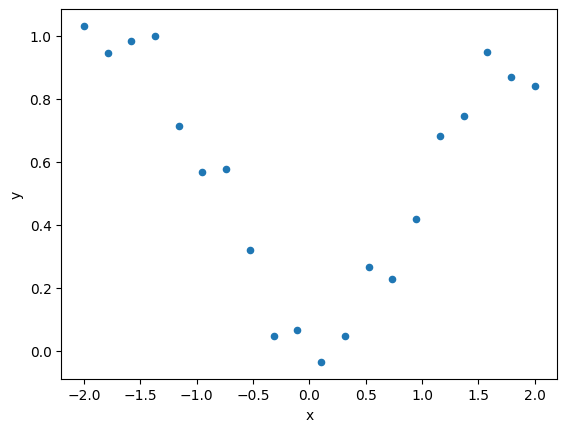

In [3]:
df.plot.scatter(x="x", y="y");

**Our goal: predict the `y` values accurately given the input `x`.**

To fit this polynomial, we will need polynomial features:

In [4]:
def polynomial_features(x, max_degree):
    return pd.DataFrame( { i: x ** i for i in range(max_degree+1) } )

X_train = polynomial_features(x, max_degree=3)
y_train = y

X_train.head()

,0,1,2,3
0,1.0,-2.000000,4.000000,-8.000000
1,1.0,-1.789474,3.202216,-5.730281
2,1.0,-1.578947,2.493075,-3.936434
3,1.0,-1.368421,1.872576,-2.562473
4,1.0,-1.157895,1.340720,-1.552413


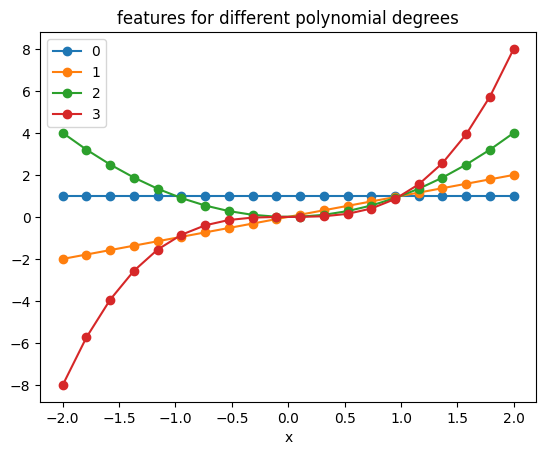

In [5]:
X_train.index = X_train[1]
ax = X_train.plot(style="o-", title="features for different polynomial degrees");
ax.set_xlabel("x");

Now let's train a linear regression model

In [6]:
from sklearn.linear_model import LinearRegression

# note: we don't need to use an "intercept" term because this is the same thing as using a
# polynomial of degree zero, which we have included in our list of features!
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [7]:
# Examine the coefficients
print(model.coef_)

[ 0.21491894 -0.08931085  0.23626116  0.01589307]


The best way of seeing that is by showing the predicted value over the train set:

In [8]:
def fit_plot(x_train, y_train, degree):
    X_train = polynomial_features(x_train, max_degree=degree)
    
    # make a test set (tightly spaced points on the x-axis)
    x_test = np.linspace(x_train.min(), x_train.max(), num=200)
    X_test = polynomial_features(x_test, max_degree=degree)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    df = pd.DataFrame({"x": x_train, "y": y_train})
    df_test = pd.DataFrame({"x": x_test, "y_pred": y_pred})

    # plot original data, then plot predictions on test set (entire x-axis)
    ax = df.plot(x="x", y="y", style="o")
    ax = df_test.plot(x="x", y="y_pred", ax=ax)
    ax.legend();
    ax.set_title("polynomial fit, degree = " + str(degree))
    ax.set_ylim(y.min()-0.1, y.max()+0.1)

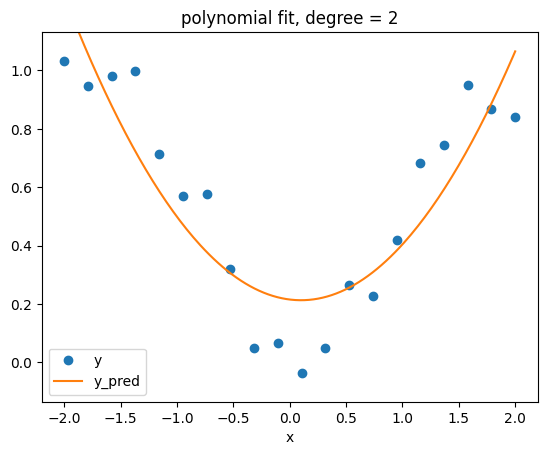

In [9]:
fit_plot(x, y, degree=2)

How should we select the polynomial degree? Re-run the cell above for different values of `degree`.
There is a trade-off between training error and test error.

## Model selection

We will use k-fold cross-validation to select the best degree to use

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

max_deg = 10
y_train = y

for d in range(max_deg+1):
    X_train = polynomial_features(x, max_degree=d)
    model = LinearRegression(fit_intercept=False)    

    # MSE averaged over all folds (using 5-fold CV)
    model_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = model_scores.mean()
    
    # MSE on the training data (entire dataset)
    y_pred = model.fit(X_train,y_train).predict(X_train)
    train_mse = mean_squared_error(y_pred,y_train)
    
    print("degree = " + str(d) + ". Train MSE = ", train_mse.round(3), ".  CV MSE = ",  cv_mse.round(3) )

degree = 0. Train MSE =  0.127 .  CV MSE =  0.191
degree = 1. Train MSE =  0.124 .  CV MSE =  0.411
degree = 2. Train MSE =  0.027 .  CV MSE =  0.06
degree = 3. Train MSE =  0.027 .  CV MSE =  0.785
degree = 4. Train MSE =  0.005 .  CV MSE =  0.182
degree = 5. Train MSE =  0.005 .  CV MSE =  0.872
degree = 6. Train MSE =  0.004 .  CV MSE =  3.04
degree = 7. Train MSE =  0.004 .  CV MSE =  13.889
degree = 8. Train MSE =  0.004 .  CV MSE =  569.423
degree = 9. Train MSE =  0.004 .  CV MSE =  2079.63
degree = 10. Train MSE =  0.003 .  CV MSE =  17085.497


*The MSE is the "mean squared error", which is RSS/n (the RSS divided by the number of data points).* 
The train MSE keeps decreasing with degree, but the MSE from using cross-validation is optimized at around degree=2.

---